# **Cleaning of dataset from OpenAlex**
- Remove duplicates
- Remove articles with missing metadata, such as 'PaperTitle', 'PubDate' or 'Abstract'
- Remove non english articles, even though marked as 'en' in the metadata
- Remove artifacts, i.e., all supplementary tables, figures and data
- Remove invalid titles, placeholders, length-based issues
- Remove withdrawn papers
- Remove'non-research' articles
- Clean, harmonize and normalize

## 1) Import libraries and load dataset

In [200]:
# Import necessary libraries
import os
import re
import pandas as pd
import time
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
from tqdm import tqdm
from rapidfuzz import fuzz
from cleantext import clean
print("Success!")

Success!


In [201]:
# Set the working directories
input_directory = "/INPUT DIRECTORY"
output_directory = "OUTPUT DIRECTORY"
print("Current Working Directory:", os.getcwd())

Current Working Directory: OUTPUT DIRECTORY


In [202]:
# Load the dataframe
file_path = "OPEN ALEX SEARCH DATASET"

# Check if OpenAlexSearch exists in the global scope
if 'OpenAlexSearch' in globals():
    OpenAlexSearch = OpenAlexSearch.copy()
    print("OpenAlexSearch copied from existing DataFrame!")
else:
    os.chdir(input_directory)
    OpenAlexSearch = pd.read_csv(file_path)

# Get the number of articles
OpenAlex_article_count = len(OpenAlexSearch)
print("Number of articles derived from OpenAlex:", f"{OpenAlex_article_count:,}")

OpenAlexSearch copied from existing DataFrame!
Number of articles derived from OpenAlex: 2,775,913


In [203]:
# Check column names
print("Column names of the dataset:", OpenAlexSearch.columns)

# Rename column 'c' to 'CoFoS'
OpenAlexSearch = OpenAlexSearch.rename(columns={'c': 'CoFoS'})
print("Column names of the dataset:",OpenAlexSearch.columns)

Column names of the dataset: Index(['PaperId', 'PaperTitle', 'Citations', 'CoFoS', 'Authors', 'Abstract',
       'Language', 'PubYear', 'PubDate'],
      dtype='object')
Column names of the dataset: Index(['PaperId', 'PaperTitle', 'Citations', 'CoFoS', 'Authors', 'Abstract',
       'Language', 'PubYear', 'PubDate'],
      dtype='object')


## 2) Removal of duplicates and empty PaperTitle/Abstract/PubDate rows

In [204]:
# Make a copy of the original dataset before cleaning
OpenAlex_rem_dup_metad = OpenAlexSearch.copy()

# Define cleaning steps and initialize tqdm progress bar
cleaning_steps = [
    "Removing missing/empty PaperId",
    "Removing duplicate PaperId entries",
    "Removing duplicate entries with identical PaperTitle & Authors",
    "Removing missing/empty PaperTitle",
    "Removing missing/empty Abstract",
    "Removing missing/empty PubDate",
    "Validating PubDate format (YYYY-MM-DD)",
    "Removing missing/empty Authors"
]
progress_bar = tqdm(total=len(cleaning_steps), desc="Cleaning Data", unit="step")

# Count initial number of rows
initial_article_count = len(OpenAlexSearch)

# Removing missing/empty PaperId
missing_paperid_count = OpenAlex_rem_dup_metad['PaperId'].isna().sum()
empty_paperid_count = (OpenAlex_rem_dup_metad['PaperId'].astype(str).str.strip() == "").sum()
OpenAlex_rem_dup_metad = OpenAlex_rem_dup_metad.dropna(subset=['PaperId'])
OpenAlex_rem_dup_metad = OpenAlex_rem_dup_metad[OpenAlex_rem_dup_metad['PaperId'].astype(str).str.strip() != ""]
progress_bar.update(1)

# Removing missing/empty PaperTitle
missing_title_count = OpenAlex_rem_dup_metad['PaperTitle'].isna().sum()
empty_title_count = (OpenAlex_rem_dup_metad['PaperTitle'].str.strip() == "").sum()
OpenAlex_rem_dup_metad = OpenAlex_rem_dup_metad.dropna(subset=['PaperTitle'])
OpenAlex_rem_dup_metad = OpenAlex_rem_dup_metad[OpenAlex_rem_dup_metad['PaperTitle'].str.strip() != ""]
progress_bar.update(1)

# Removing missing/empty Abstract
missing_abstract_count = OpenAlex_rem_dup_metad['Abstract'].isna().sum()
empty_abstract_count = (OpenAlex_rem_dup_metad['Abstract'].str.strip() == "").sum()
OpenAlex_rem_dup_metad = OpenAlex_rem_dup_metad.dropna(subset=['Abstract'])
OpenAlex_rem_dup_metad = OpenAlex_rem_dup_metad[OpenAlex_rem_dup_metad['Abstract'].str.strip() != ""]
progress_bar.update(1)

# Removing missing/empty Authors
missing_authors_count = OpenAlex_rem_dup_metad['Authors'].isna().sum()
empty_authors_count = (OpenAlex_rem_dup_metad['Authors'].astype(str).str.strip() == "").sum()
OpenAlex_rem_dup_metad = OpenAlex_rem_dup_metad.dropna(subset=['Authors'])
OpenAlex_rem_dup_metad = OpenAlex_rem_dup_metad[OpenAlex_rem_dup_metad['Authors'].astype(str).str.strip() != ""]
progress_bar.update(1)

# Removing missing/empty PubDate
missing_pubdate_count = OpenAlex_rem_dup_metad['PubDate'].isna().sum()
empty_pubdate_count = (OpenAlex_rem_dup_metad['PubDate'].astype(str).str.strip() == "").sum()
OpenAlex_rem_dup_metad = OpenAlex_rem_dup_metad.dropna(subset=['PubDate'])
OpenAlex_rem_dup_metad = OpenAlex_rem_dup_metad[OpenAlex_rem_dup_metad['PubDate'].astype(str).str.strip() != ""]
progress_bar.update(1)

# Validate PubDate format (YYYY-MM-DD)
def is_valid_date(date_str):
    return bool(re.match(r'^\d{4}-\d{2}-\d{2}$', str(date_str)))
invalid_pubdate_count = OpenAlex_rem_dup_metad[~OpenAlex_rem_dup_metad['PubDate'].astype(str).apply(is_valid_date)].shape[0]
OpenAlex_rem_dup_metad = OpenAlex_rem_dup_metad[OpenAlex_rem_dup_metad['PubDate'].astype(str).apply(is_valid_date)]
progress_bar.update(1)

# Removing duplicate PaperId entries
duplicate_paperid_count = OpenAlex_rem_dup_metad.duplicated(subset=['PaperId']).sum()
OpenAlex_rem_dup_metad = OpenAlex_rem_dup_metad.drop_duplicates(subset=['PaperId'], keep='first')
progress_bar.update(1)

# Removing duplicate entries with identical PaperTitle & Authors
OpenAlex_rem_dup_metad["_temp_PaperTitle"] = OpenAlex_rem_dup_metad["PaperTitle"].str.lower()
OpenAlex_rem_dup_metad["_temp_Authors"] = OpenAlex_rem_dup_metad["Authors"].str.lower()
duplicate_entries_count = OpenAlex_rem_dup_metad.duplicated(subset=["_temp_PaperTitle", "_temp_Authors"]).sum()
OpenAlex_rem_dup_metad = OpenAlex_rem_dup_metad.drop_duplicates(subset=["_temp_PaperTitle", "_temp_Authors"], keep="first")
OpenAlex_rem_dup_metad.drop(columns=["_temp_PaperTitle", "_temp_Authors"], inplace=True)
progress_bar.update(1)           

# Close the progress bar
progress_bar.close()

# Count final number of rows after all removals
article_count_after_duplicates_and_missings = len(OpenAlex_rem_dup_metad)
total_removed = initial_article_count - article_count_after_duplicates_and_missings

# Sum the duplicate removals
total_duplicates_removed = duplicate_paperid_count + duplicate_entries_count

# Sum the missing removals
missing_values = (
    missing_paperid_count + empty_paperid_count +
    missing_title_count + empty_title_count +
    missing_abstract_count + empty_abstract_count +
    missing_pubdate_count + empty_pubdate_count + invalid_pubdate_count +
    missing_authors_count + empty_authors_count
)

# Collect removal statistics
removal_log = [
    f"Initial number of articles: {initial_article_count:,}",
    f"\n-Removed due to missing PaperId (NaN): {missing_paperid_count:,}",
    f"-Removed due to empty PaperId (''): {empty_paperid_count:,}", 
    f"-Removed due to missing PaperTitle (NaN): {missing_title_count:,}",
    f"-Removed due to empty PaperTitle (''): {empty_title_count:,}",
    f"-Removed due to missing Abstract (NaN): {missing_abstract_count:,}",
    f"-Removed due to empty Abstract (''): {empty_abstract_count:,}",
    f"-Removed due to missing PubDate (NaN): {missing_pubdate_count:,}",
    f"-Removed due to empty PubDate (''): {empty_pubdate_count:,}",
    f"-Removed due to invalid PubDate format (not YYYY-MM-DD): {invalid_pubdate_count:,}",
    f"-Removed due to missing Authors (NaN): {missing_authors_count:,}",
    f"-Removed due to empty Authors (''): {empty_authors_count:,}",
    f"-Removed due to duplicate PaperId entries: {duplicate_paperid_count:,}",
    f"-Removed due to duplicate entries with identical PaperTitle & Authors: {duplicate_entries_count:,}", 
    
    f"\nTotal articles with missing data removed: {missing_values:,}", 
    f"Total duplicate entries removed: {total_duplicates_removed:,}", 
    f"Total articles removed: {total_removed:,}",
    
    f"\nFinal number of articles after cleaning steps: {article_count_after_duplicates_and_missings:,}"
]

# Print removal details
print("\n".join(removal_log))

# Save the DataFrame as a CSV file
os.chdir(output_directory)
output_file_path = os.path.join(output_directory, "OpenAlex_rem_dup_metad.csv")
OpenAlex_rem_dup_metad.to_csv(output_file_path, index=False)
print(f"Saved successfully as: {output_file_path}")


Cleaning Data:  88%|██████████████████████████████████████████████████████████████████████          | 7/8 [00:22<00:02,  2.87s/step]

KeyboardInterrupt: 

## 3) Removal of articles in languages other than "en", even though set to "en" in metadata

- This step is using an NER-based approach, so in this case (2.7 M articles) it is takinng about 2h.

In [ ]:
# Load dataframe
file_path = os.path.join(output_directory, "OpenAlex_rem_dup_metad.csv")

# Check if OpenAlex_rem_dup_metad exists
if 'OpenAlex_rem_dup_metad' in globals():
    df_filtered = OpenAlex_rem_dup_metad.copy()
    print("df_filtered copied from existing OpenAlex_rem_dup_metad DataFrame!")
else:
    os.chdir(output_directory)
    df_filtered = pd.read_csv(file_path)
    print("df_filtered loaded from OpenAlex_rem_dup_metad.csv in output directory.")

In [ ]:
# Progress bar
tqdm.pandas()

# Ensure consistent language detection (fixes randomness)
DetectorFactory.seed = 0  

# Start tracking runtime
start_time = time.time()

# Function to detect language separately for PaperTitle and Abstract with retry logic
def detect_language(row):
    try:
        title = str(row['PaperTitle']).strip().lower() if pd.notna(row['PaperTitle']) else ""
        abstract = str(row['Abstract']).strip() if pd.notna(row['Abstract']) else ""

        # Apply language detection with retry mechanism
        def safe_detect(text, max_retries=3):
            for _ in range(max_retries):
                try:
                    return detect(text) if len(text) > 10 else "unknown" 
                except:
                    pass
            return "error"

        title_lang = safe_detect(title)
        abstract_lang = safe_detect(abstract)
        return "en" if title_lang == "en" or abstract_lang == "en" else "non-en"

    except Exception:
        return "error"

# Apply language detection with progress bar on the full dataset
df_filtered["detected_language"] = df_filtered.progress_apply(detect_language, axis=1)

# Separate English and non-English articles (Keep if AT LEAST ONE column is English)
df_filtered_cleaned = df_filtered[df_filtered["detected_language"] == "en"].drop(columns=["detected_language"])
df_dropped = df_filtered[df_filtered["detected_language"] != "en"]

# Store lengths in variables
total_rows_before = len(df_filtered)
dropped_rows = len(df_dropped)
total_rows_after = len(df_filtered_cleaned)

# Stop tracking runtime
end_time = time.time()
runtime_seconds = end_time - start_time
runtime_minutes = runtime_seconds / 60

# Save results
os.chdir(output_directory)
df_dropped.to_csv(os.path.join(output_directory, "OpenAlexSearch_non_english.csv"), index=False)
df_filtered_cleaned.to_csv(os.path.join(output_directory, "OpenAlexSearch_language_filtered.csv"), index=False)

# Save runtime and stats to a text file
summary_log_path = os.path.join(output_directory, "language_filter_summary.txt")
with open(summary_log_path, "w") as f:
    f.write(f"Language filtering runtime: {runtime_seconds:.2f} seconds ({runtime_minutes:.2f} minutes)\n")
    f.write(f"Total rows before filtering: {total_rows_before:,}\n")
    f.write(f"Non-English articles removed (dropped_rows): {dropped_rows:,}\n")
    f.write(f"Total rows after filtering: {total_rows_after:,}\n")
print(f"Language filtering complete. Non-English articles removed: {dropped_rows:,}.")
print(f"Total time: {runtime_seconds:.2f} seconds ({runtime_minutes:.2f} minutes).")

In [ ]:
# Print summary
print(f"Language filtering completed in {runtime_seconds:,.2f} seconds")
print(f"Total rows before language filtering: {total_rows_before:,}")
print(f"Non-English articles removed: {dropped_rows:,}")

print(f"Total rows after language filtering: {total_rows_after:,}")
print(f"Total rows after language filtering: {len(df_filtered_cleaned):,}")

# Investigate dropped rows
print("\nDropped rows:")
print(df_dropped[['PaperTitle']].head(20))
print(df_dropped[['Abstract']].head(20))
print(f"\nTotal non-English articles removed: {len(df_dropped):,}")

In [ ]:
# Count non-english output
file_path = "OpenAlexSearch_language_filtered.csv"
# Check if df_filtered exists in the global scope
if 'df_filtered_cleaned' in globals():
    clean_df_step1 = df_filtered_cleaned.copy()
    print("df_filtered copied from existing DataFrame!")
else:
    os.chdir(output_directory)
    clean_df_step1 = pd.read_csv(file_path)
    print("File loaded successfully!")
    

# Count non-English articles
nonenglish_articles = len(df_dropped)
print(f"Number of non-English articles: {nonenglish_articles:,}")
print(f"Number of English articles from old dataframe: {len(df_filtered_cleaned):,}")
print(f"Number of English articles from new dataframe: {len(clean_df_step1):,}")

## 4) Remove artifacts, i.e., all supplementary tables, figures and data

In [ ]:
# Load dataframe
file_path = "OpenAlexSearch_language_filtered.csv"
# Check if df_filtered exists in the global scope
if 'df_filtered_cleaned' in globals():
    clean_df_step1 = df_filtered_cleaned.copy()
    print("df_filtered copied from existing DataFrame!")
else:
    os.chdir(output_directory)
    clean_df_step1 = pd.read_csv(file_path)
    print(f"File loaded successfully! Rows: {len(clean_df_step1)}")
print(f"Len of dataset: {len(clean_df_step1):,}")

In [ ]:
# Start tracking runtime
tqdm.pandas()
start_time = time.time()

# Keywords to match at the start of the PaperTitle column (sorted, formatted)
all_keywords = sorted([
    "Acknowledgments", "ADOBE PDF", "Addendum", "Advertisement", "Additional figure", "Additional Material", 
    "Additional Table", "All Supplemental Data", "All Supplemental Figures", 
    "All Supplemental Figures, Tables and Legends", "All Supplementary Data", 
    "All Supplementary Figures", "All Supplementary Figures and Tables", 
    "All Supplementary Tables, Figures and Methods", "Analysis Methods Supplement", 
    "Appendix", "Article figures", "Author Correction", "Auxiliary Supplementary File", 
    "Caption for Suppl Fig.", "Captions of supplementary", "Combined supplemental figures", 
    "Contents Vol", "Contents:",
    "Corrigendum", "Correction", "Correction to", "Correction:", "Corrections to", 
    "Data Augmentation", "Data associated with", "Data and code", "Data and analysis scripts", "Data File", 
    "Data for", "Data from", "Data not shown", "Data and metadata",
    "Data on", "Data S", "Data Spreadsheet", "Data Supplement", "Data.zip", 
    "Dataset", "Dataset and metadata", "Dataset for", "Dataset related to", 
    "Description of Supplemental Figures", "Description of supplementary", 
    "Download Supplementary", "eFigure", "Erratum", "Extended Data", "Expression of Concern",
    "Fig", "Fig.", "Fig Supp", "FigS", "Figure", "Figure S", "Figures", "Instructions for Authors",
    "File", "Funding statement", "http://", "https://", 
    "Legend for", "Legend from", "Legend of", "Legend to", 
    "Legends for", "Legends from", "Legends of", "Legends to", 
    "Legends Supplemental Figures", "Link to Supplementary", 
    "List of figures", "List of tables", "List of plates", "Manuscript Figures", 
    "Mat & Met", "Material and Methods", "Materials and Methods", 
    "Merged Supplementary", "Metadata and data", "Metadata record for", 
    "Metadata supporting", "Methods References", "Methods and Materials from", 
    "Methods and Supplementary", "Methods and Tables", "Methods file", 
    "Methods from", "Methods, Figures", "Methods, Table", "MET supplementary methods", 
    "methods_", "Movie", "Multimedia", "Methodology and Method", "Online supplement", 
    "Online Supplementary Materials", "Online Supplementary Tables", 
    "Online-only supplementary", "Online-Only Tables", 
    "Original Western Blot Data", "Revised Supplementary", "S Figure", "S Table", 
    "S-Figure", "S1 Legend", "S1 from", "S1.", "S1:", "S2 from", "S2.", "S2:", 
    "S3 from", "S3.", "S3:", "S4 from", "S4.", "S4:", "S5 from", "S5.", "S5:", 
    "S6 from", "S6.", "S6:", "S7 from", "S7.", "S7:", "S8 from", "S8.", "S8:", 
    "S9 from", "S9.", "S9:", "SI Figure", "SI Methods", "SI Table", 
    "SI materials", "SI tables and figures", "SFigure", "SF-", "SF1", 
    "Sl Figure", "Supplement", "Supplement Material", "Supplement Table", 
    "Supplemental", "Supplemental Data", "Supplemental Figure", 
    "Supplemental Figures", "Supplemental Table", "Supplementary", 
    "Supplementary Data", "Supplementary Figure", "Supplementary Figures", 
    "Supplementary Legends", "Supplementary Methods", "Supplementary Movie", 
    "Supplementary Table", "Supplementary Tables", "Supplementary Text", 
    "Supplementary Video", "SupplementaryFigures", "Supplementary_Figure", 
    "Supplementray Figures", "Supplementray Tables", "Supplymentary Figure", 
    "Supplymentary Figures", "Supplymentary Table", "Supporting Data", 
    "Supporting Document", "Supporting Figure", "Supporting Figures", 
    "Supporting File", "Supporting Information", "Supporting Legend", 
    "Supporting Legends", "Supporting Materials", "Supporting Methods", 
    "Supporting Table", "Supporting Tables", "Supporting Text", 
    "Supporting Video", "Suppl", "Suppl Figure", "Suppl Figures", "Suppl File", 
    "Suppl Info", "Suppl Information", "Suppl Legends", "Suppl List of Videos, Tables and Methods", 
    "Suppl Materials and Methods", "Suppl Methods", "Suppl Movie", "Suppl Table", 
    "Suppl Video", "Supplimentary Figure", "Supplimentary Methods", 
    "Supplimentary Tables", "Supplimentary_Figure", "Suplementary", "Supllementary Figure", 
    "Suplplementary Figure Legend", "Suplpementary Table", "Supplrmentary Figures", 
    "Supplrmentary Tables", "Suppltable", "Suppltext", "Supplvideo", 
    "Suppl_Figure", "Suppl-Figure", "Suupplementary Tables", "Table", "Table of Content",
    "Validation Figures", "Video", "Western Blots from", "Whole Slide Image"
])

# Keywords to match anywhere in the PaperTitle column (sorted, formatted)
middle_keywords = sorted([
    "Combined Supplementary Materials", "Corrigendum", "The Case Files", "Additional file",
    "Figure S", "Figures S", "Manuscript Figures", "SI tables and figures", 
    "Supplemental Data", "Supplemental figures", "Supplemental from", 
    "Supplemental table", "Supplemental figure", "Supplementary Figure", 
    "Supplementary Figures", "Supplementary Material", "Supplementary Methods", 
    "Supplementary Table", "Supplementary Tables", "Supplementary data", 
    "Supplementary document", "Supplementary information", "SupplementaryFigures", 
    "Supplementary materials and methods", 
    "Translation for the Article", "Video Dataset", "Operative Video"
])


# Compile regex patterns for faster execution
start_pattern = re.compile(r"^(?:" + "|".join(map(re.escape, all_keywords)) + r")", re.IGNORECASE)
middle_pattern = re.compile(r"\b(?:{})\b".format("|".join(map(re.escape, middle_keywords))), re.IGNORECASE)
supplementary_pattern = re.compile(r"[\w\-_]*supple\w*", re.IGNORECASE)

# Count initial rows
rows_before_artifacts = len(clean_df_step1)

# Apply filtering with a progress bar
tqdm.pandas(desc="Filtering Data")

clean_df_step1 = clean_df_step1[
    ~clean_df_step1["PaperTitle"].progress_apply(lambda title: bool(start_pattern.match(str(title)))) &
    ~clean_df_step1["PaperTitle"].progress_apply(lambda title: bool(middle_pattern.search(str(title)))) &
    ~clean_df_step1["PaperTitle"].progress_apply(lambda title: "_" in str(title)) &
    ~clean_df_step1["PaperTitle"].progress_apply(lambda title: bool(supplementary_pattern.search(str(title))))
]

# Count remaining and removed rows
final_row_count = len(clean_df_step1)
artifacts_removed = rows_before_artifacts - final_row_count

# Display results
print(f"\nInitial number of rows before artifact removal: {rows_before_artifacts:,}")
print(f"Number of rows identified as artifacts and removed: {artifacts_removed:,}")
print(f"Final number of rows in the cleaned dataset: {final_row_count:,}")
clean_df_step1.to_csv("filtered_clean_after_artifactremoval.csv", index=False)

# End tracking runtime
end_time = time.time()
print(f"Processing completed in {end_time - start_time:.2f} seconds.")

## 5) Removing invalid titles, placeholders, length-based issues,  withdrawn papers, and 'non-research' articles

In [216]:
# Load dataframe
file_path = "filtered_clean_after_artifactremoval.csv"

# Check if cleaned_df exists in the global scope
if 'clean_df_step1' in globals():
    clean_df_step2 = clean_df_step1.copy()
    print("cleaned_df copied from existing DataFrame!")
else:
    os.chdir(output_directory)
    clean_df_step1 = pd.read_csv(file_path)
    clean_df_step2 = clean_df_step1.copy()

    # Store initial row count before cleaning
    article_count_before_invalid = len(cleaned_df)
    print(f"File loaded successfully! Row count: {article_count_before_invalid}")
    
print(f"Len clean_df_step1: {len(clean_df_step1):,}")
print(f"Check len clean_df_step2: {len(clean_df_step2):,}")

cleaned_df copied from existing DataFrame!
Len clean_df_step1: 2,384,863
Check len clean_df_step2: 2,384,863


In [217]:
# Store initial article count
article_count_before_invalid = len(clean_df_step1)

# ================================================

# Initialize removal counts
nonsense_title_counts = 0
title_length_counts = 0
abstract_length_counts = 0
withdraw_counts = 0
non_research_counts = 0

# Define cleaning steps for progress bar
new_cleaning_steps = [
    "Removing numeric/nonsense titles",
    "Removing placeholder titles",
    "Filtering by title length",
    "Filtering by abstract length",
    "Removing withdrawn/withdrawal articles",
    "Removing non-research articles (Editorials, News, etc.)"
]
progress_bar = tqdm(total=len(new_cleaning_steps), desc="Additional Cleaning", unit="step")

# ========== Removing numeric/nonsense titles ==========
pattern_numeric = re.compile(r'^[^A-Za-z]+$')  # Matches titles with no letters (only numbers/symbols)
mask_numeric = clean_df_step2["PaperTitle"].apply(lambda title: bool(pattern_numeric.match(str(title))))
nonsense_title_counts += mask_numeric.sum()
clean_df_step2 = clean_df_step2[~mask_numeric]
progress_bar.update(1)
print(f"Identified numeric/nonsense titles: {mask_numeric.sum():,}")

# ========== Removing placeholder titles ==========
placeholders = {
    "Title Not Available", "No Title", "Untitled", "N/A",
    "[No title available]", "No title available", "No title available - PubMed",
    "Error in Text", "Errors in Box", "Error in Author Name", "Error in Author Names",
    "Error in Author Surnames", "Errors in article text", "Error in Figure Label and Caption",
    "Error in Presentation of Author", "Errors in Author Name", "Error in Author Name",
    "Error in Table Text","Error in Corresponding Authorship",
}

placeholder_pattern = re.compile(
    r"\b(?:{})\b".format("|".join(map(re.escape, placeholders))), re.IGNORECASE
)
mask_placeholders = clean_df_step2["PaperTitle"].apply(lambda title: bool(placeholder_pattern.search(str(title))))
print(f"Identified placeholders: {mask_placeholders.sum():,}")
nonsense_title_counts += mask_placeholders.sum()
clean_df_step2 = clean_df_step2[~mask_placeholders]
progress_bar.update(1)

# ========== Filtering by title length ==========
def count_real_words(text):
    words = re.findall(r'\b[a-zA-Z]{2,}\b', str(text))
    return len(words)

def valid_title_length(title, min_words=3, max_words=60):
    return min_words <= count_real_words(title) <= max_words

clean_df_step2 = clean_df_step2.reset_index(drop=True)
mask_valid_title = clean_df_step2["PaperTitle"].apply(valid_title_length)

title_length_counts = (~mask_valid_title).sum()
print(f"Invalid PaperTitle count (too short/long): {title_length_counts:,}")

# Remove invalid titles first
clean_df_step2 = clean_df_step2[mask_valid_title]
progress_bar.update(1)

# ========== Filtering by abstract length ==========
def valid_abstract_length(abstract, min_words=80, max_words=1000):
    return min_words <= count_real_words(abstract) <= max_words

mask_valid_abstract = clean_df_step2["Abstract"].apply(valid_abstract_length)
abstract_length_counts = (~mask_valid_abstract).sum()

print(f"Invalid Abstract count (too short/long): {abstract_length_counts:,}")

# Remove invalid abstracts (after title filtering)
clean_df_step2 = clean_df_step2[mask_valid_abstract]
progress_bar.update(1)

# ========== Removing withdrawn/retracted papers ==========
withdrawn_retraction_pattern = re.compile(
    r"(?i)^(?:\[?)?(Withdrawn|Withdrawal|Retracted|Retraction|Errata|Erratum|Revoked|Removed|Correction Notice|Corrigendum)\b"
)
mask_withdrawn = clean_df_step2["PaperTitle"].apply(lambda title: bool(withdrawn_retraction_pattern.search(str(title))))
withdraw_counts = mask_withdrawn.sum()
clean_df_step2 = clean_df_step2[~mask_withdrawn]
progress_bar.update(1)
print(f"Identified withdrawn: {withdraw_counts:,}")


# ========== Removing non-research articles ==========
non_research_keywords = [
    "A reply to Letter to the editor", "About the Author", "An Update from the Editor-in-Chief",
    "Announcement:", "Announcements", "Appeal", "ASO Author Reflection", "AUTHOR COPY ONLY", 
    "Associate Editor", "Author comment:", "Author profile", "Author Reflections:", "Author reply", 
    "Author response", "Author response to", "Author view", "Author's reply", "Author's respond", 
    "Editor's Reflection", "Editors Reflection", "Editors' Reflection", "Editor' Reflection",
    "Author's response", "Author's view", "Authors reply", "Authors respond", "Authors response", 
    "Authors view", "Authors' Reply", "Authors' response", "Authors's response", "Book Review", "EditorinChief",
    "Comment", "Comment on", "Commentary", "Conference Summary", "Conversation with the Editor", 
    "Correspondence", "Editorial", "Editor Profile", "Editor response for", "Editor change", "New Editor",
    "Editor-in-Chief", "Editorinchief's introduction", "Editor's evaluation", "Editor's Introduction", 
    "Editor's Message", "Editor's note", "Editors Introduction", "Editors Message", "Editors Note on", 
    "Editors Spotlight", "Editors change", "Editors note", "Editors' Introduction", "Editors' Message", 
    "Editors' note", "Foreword", "From the Editor", "From the Editor-in-Chief", "From the Editors...", 
    "From the Editors Desk...", "From the Editor's desk", "From the editors desk", "From the Guest Editor", "Guest editor",
    "Guest editorial", "Introducing our new Editors", "Issue Editor Foreword", "Issue Information Editorial Board", 
    "Letter to editor", "Letter to the Editor", "Letter:", "Letter Of The Editor", "Letters of the editor", "Letter-to-the-editor", 
    "Letters to editor", "Letters to the editor", "Meet the First Author", "Meet the author", "Meet the editor", 
    "Message from Editor", "Message from the Editor", "News", "Opinion", "our author", "our editor", 
    "Reply:", "In reply:", "Reply to:", "In reply to:",
    "Perspective", "Preface", "Proceedings", "Publisher'?s? Note", "Reply by Author", "Reply by the author", 
    "Reply to Editorial Comment", "Reply to Letter to", "Reply to correspondence", "Reply to the Letter to", 
    "Response to Editorial", "Response to a letter", "Response to letter", "senior editor", "Special Section", 
    "The Author Reply", "The Authors Reply", "To the Editor", "Transitioning Between Editor", "Viewpoint", 
    "Welcome to our", "Executive Editor","Assistant Editor",
]


# Convert keywords into a single regex pattern (match anywhere in the title)
escaped_keywords = [re.escape(keyword) for keyword in non_research_keywords]
non_research_pattern = "|".join(escaped_keywords)  # No caret (^) to match anywhere

clean_df_step2["PaperTitle"] = clean_df_step2["PaperTitle"].fillna("").str.strip().str.replace(r"\s+", " ", regex=True)
mask_non_research = clean_df_step2["PaperTitle"].str.contains(non_research_pattern, case=False, na=False)
non_research_counts = mask_non_research.sum()
clean_df_step2 = clean_df_step2[~mask_non_research]
progress_bar.update(1)
print(f"Identified non-research articles: {non_research_counts:,}")

progress_bar.close()

# ========== Compute final counts ==========
# Calculate total removed
total_removed = (
    nonsense_title_counts
    + title_length_counts
    + abstract_length_counts
    + withdraw_counts
    + non_research_counts
)
final_article_count = len(clean_df_step2)

# ========== Final summary & consistency check ==========
removal_log = [
    f"Initial count: {article_count_before_invalid:,}",
    f"Removed numeric/nonsense titles & placeholders: {nonsense_title_counts:,}",
    f"Removed due to title length issues: {title_length_counts:,}",
    f"Removed due to abstract length issues: {abstract_length_counts:,}",
    f"Removed withdrawn articles: {withdraw_counts:,}",
    f"Removed non-research articles: {non_research_counts:,}",
    f"Final number of articles: {final_article_count:,}",
    f"\nTotal removed (should match sum above): {total_removed:,}"
]

print("\n".join(removal_log))

# Sanity check
expected_total_removed = (
    nonsense_title_counts
    + title_length_counts
    + abstract_length_counts
    + withdraw_counts
    + non_research_counts
)

if total_removed == expected_total_removed:
    print(f"Total removed articles match: {total_removed:,}")
else:
    print(f"Mismatch detected!")
    print(f"Expected total removed: {expected_total_removed:,}")
    print(f"Actual total removed: {total_removed:,}")
    print(f"Difference: {abs(expected_total_removed - total_removed):,}")

# Save final cleaned dataset
clean_df_step2.to_csv("clean_df_step2.csv", index=False)
print("\nDataset saved as 'clean_df_step2.csv'.")

Additional Cleaning:  17%|████████████▎                                                             | 1/6 [00:01<00:05,  1.18s/step]

Identified numeric/nonsense titles: 2,302
Identified placeholders: 34


Additional Cleaning:  33%|████████████████████████▋                                                 | 2/6 [00:15<00:36,  9.02s/step]

Invalid PaperTitle count (too short/long): 15,561


Additional Cleaning:  50%|█████████████████████████████████████                                     | 3/6 [00:24<00:26,  8.97s/step]

Invalid Abstract count (too short/long): 214,006


Additional Cleaning:  83%|█████████████████████████████████████████████████████████████▋            | 5/6 [02:21<00:33, 33.04s/step]

Identified withdrawn: 2,422


Additional Cleaning: 100%|██████████████████████████████████████████████████████████████████████████| 6/6 [06:54<00:00, 69.01s/step]


Identified non-research articles: 19,793
Initial count: 2,384,863
Removed numeric/nonsense titles & placeholders: 2,336
Removed due to title length issues: 15,561
Removed due to abstract length issues: 214,006
Removed withdrawn articles: 2,422
Removed non-research articles: 19,793
Final number of articles: 2,130,745

Total removed (should match sum above): 254,118
Total removed articles match: 254,118

Dataset saved as 'clean_df_step2.csv'.


## 6) Cleaning, harmonizing and normalization of PaperTitles and Abstracts

In [218]:
# Load dataframe
file_path = "clean_df_step2.csv"
if 'clean_df_step2' in globals():
    clean_df_step3 = clean_df_step2.copy()
    print("clean_df_step3 copied from clean_df_step2!")
else:
    os.chdir(output_directory)
    clean_df_step2 = pd.read_csv("clean_df_step2.csv")
    clean_df_step3 = clean_df_step2.copy()
    print("File loaded successfully!")
    
print(f"Len df2: {len(clean_df_step2):,}")
print(f"Len df3: {len(clean_df_step3):,}")

clean_df_step3 copied from clean_df_step2!
Len df2: 2,130,745
Len df3: 2,130,745


In [219]:
# Store initial row count before cleaning
cleaning_step2_count = len(clean_df_step2)

# Define cleaning function for "PaperTitle"
def clean_paper_title(title):
    if not isinstance(title, str) or title.strip() == "":
        return None  # Return None for empty or non-string values.

    # Use clean-text to clean the title
    title = clean(
        title,
        fix_unicode=True,  # Fix broken unicode characters
        to_ascii=True,     # Transliterate to closest ASCII characters
        lower=False,       # Preserve original casing
        no_line_breaks=True,  # Remove line breaks
        no_urls=True,      # Remove URLs
        no_emails=True,    # Remove email addresses
        no_phone_numbers=True,  # Remove phone numbers
        no_numbers=False,  # Retain numbers
        no_digits=False,   # Retain digits
        no_currency_symbols=True,  # Remove currency symbols
        no_punct=False
    )

    # Additional custom cleaning specific to titles
    title = title.strip()

    # Remove titles that are just numbers or codes
    if re.fullmatch(r"^\d+$", title):  # Only numbers → Remove
        return None

    # Convert ALL CAPS to Title Case
    if title.isupper():
        title = title.title()

    # Remove non-informative titles
    if len(title) <= 3 or re.fullmatch(r"[^A-Za-z0-9]+", title):
        return None

    return title

# Define cleaning function for "Abstract"
def clean_abstract(abstract):
    if not isinstance(abstract, str) or abstract.strip() == "":
        return None

    abstract = clean(
        abstract,
        fix_unicode=True,
        to_ascii=True,
        lower=False,
        no_line_breaks=False,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="<URL>",
    )

    # Trim whitespace
    abstract = abstract.strip()

    # Remove abstracts that start with specific unwanted text
    blocked_phrases = [
        "Our website uses cookies to enhance your experience.",
        "(Cell Reports"
    ]
    
    # Check if abstract starts with any blocked phrase
    if any(abstract.startswith(phrase) for phrase in blocked_phrases):
        return None  # Mark it as None (to be dropped later)
    return abstract

# Apply cleaning functions
clean_df_step3 = clean_df_step2.copy()  # Ensure clean_df_step3 is defined

clean_df_step3["PaperTitle"] = clean_df_step3["PaperTitle"].progress_apply(clean_paper_title)
clean_df_step3["Abstract"] = clean_df_step3["Abstract"].progress_apply(clean_abstract)

# Remove rows where "PaperTitle" has 2 or fewer words
def has_min_words(title, min_words=3):
    """Check if title has at least the required number of words."""
    if not isinstance(title, str):
        return False
    return len(title.split()) >= min_words

mask_valid_title = clean_df_step3["PaperTitle"].progress_apply(lambda title: has_min_words(title, 3))
clean_df_step3 = clean_df_step3[mask_valid_title]

# Drop any rows where "PaperTitle" or "Abstract" is now empty
clean_df_step3 = clean_df_step3.dropna(subset=["PaperTitle", "Abstract"]).reset_index(drop=True)

# Store final row count after cleaning
final_cleaning_step3_count = len(clean_df_step3)
cleaning_step3_rows_removed = cleaning_step2_count - final_cleaning_step3_count

# Save the cleaned dataset
clean_df_step3.to_csv("clean_df_step3.csv", index=False)

# Print summary
print("\nCleaning complete!")
print(f"Initial number of articles: {cleaning_step2_count}")
print(f"Final number of articles after cleaning: {final_cleaning_step3_count}")
print(f"Total number of removed articles: {cleaning_step3_rows_removed}")

100%|█████████████████████████████████████████████████████████████████████████████████| 2130745/2130745 [00:02<00:00, 803394.76it/s]



Cleaning complete!
Initial number of articles: 2130745
Final number of articles after cleaning: 2128318
Total number of removed articles: 2427


In [ ]:
# More specific normalization of PaperTitle and Abstracts, without removing any furhter columns

file_path = "clean_df_step3.csv"

if 'clean_df_step3' in globals():
    clean_df_step4 = clean_df_step3.copy()
    print("clean_df_step4 copied from clean_df_step3!")
else:
    os.chdir(output_directory)
    clean_df_step3 = pd.read_csv(file_path)
    clean_df_step4 = clean_df_step3.copy()
    print("File loaded successfully!")

    
# Store initial row count before cleaning
cleaning_step3_count = len(clean_df_step3)

# Enable tqdm progress bars for pandas operations
tqdm.pandas()

# Helper function to convert ALL CAPS text to sentence case
def to_sentence_case(text):
    if text.isupper():  # Check if it's all caps
        return text.capitalize()  # Convert to sentence case
    return text  # Return unchanged if not all caps

# Cleaning function for PaperTitle
def clean_paper_title(title):
    if not isinstance(title, str) or title.strip() == "":
        return title 
    
    # Remove unwanted keywords at the beginning of the title
    title = re.sub(
        r"^\s*(\*?\[?(invited|keynote|winner|regular paper|blog)\]?\*?)\s*[:\-]*",
        "",
        title,
        flags=re.IGNORECASE
    )
    title = re.sub(r"[_-]{5,}", "", title)  # Remove long underscores or dashes
    title = re.sub(r"^\s*[_]*Abstract[_]*\s*[:\-]*", "", title, flags=re.IGNORECASE)  # Remove "Abstract" heading
    title = re.sub(r"^\s*[\.\,\-\:\;\//\=\s]+", "", title)  # Remove leading . , - : ; // = and spaces
    title = re.sub(r"^\[([^\]]+)\]\.?\s*$", r"\1", title)  # Remove surrounding square brackets + trailing dot
    title = re.sub(r"\s+", " ", title).strip()  # Normalize spaces
    title = to_sentence_case(title)  # Convert to sentence case if all caps
    return title

# Cleaning function for Abstract
def clean_abstract(abstract):
    if not isinstance(abstract, str) or abstract.strip() == "":
        return abstract

    # Remove everything before "introduction" if abstract starts with "You have access"
    if abstract.lower().startswith("you have access"):
        match = re.search(r"\bintroduction\b", abstract, re.IGNORECASE)
        if match:
            abstract = abstract[match.start():]  # Keep everything from "introduction" onwards

    # If it starts with "//", remove everything until "abstract" appears
    if abstract.startswith("//"):
        match = re.search(r"\babstracts?\b", abstract, re.IGNORECASE)
        if match:
            abstract = abstract[match.start():]  # Keep only the part after "abstract"

    # Remove leading colons and spaces
    abstract = re.sub(r"^\s*[:]+\s*", "", abstract)  # Remove any leading : and spaces

    # Remove long underscores/dashes at the start
    abstract = re.sub(r"[_-]{5,}", "", abstract)  # Remove long underscores or dashes
    abstract = re.sub(r"^\s*[_]*Abstract[_]*\s*[:\-]*", "", abstract, flags=re.IGNORECASE)  # Remove "Abstract" heading
    abstract = re.sub(r"^\s*[\.\,\-\:\;\=\s]+", "", abstract)  # Remove leading . , - : ; = and spaces
    abstract = re.sub(r"\s*<[^>]+>\s*", " ", abstract)  # Remove XML-like tags like <CUR>
    abstract = re.sub(r"[,\.]{2,}", ".", abstract)  # Normalize excessive dots and commas
    abstract = re.sub(r"\s+", " ", abstract).strip()  # Normalize spaces

    abstract = to_sentence_case(abstract)  # Convert to sentence case if all caps

    return abstract

# Apply cleaning with progress bar
print("\nCleaning 'PaperTitle' column...")
clean_df_step4["PaperTitle"] = clean_df_step4["PaperTitle"].progress_apply(clean_paper_title)

print("\nCleaning 'Abstract' column...")
clean_df_step4["Abstract"] = clean_df_step4["Abstract"].progress_apply(clean_abstract)

# Store initial row count after cleaning
cleaning_step4_count = len(clean_df_step4)
cleaning_step4_rows_removed = cleaning_step3_count - cleaning_step4_count

cleaning_allstep_rows_removed = cleaning_step3_rows_removed+cleaning_step4_rows_removed
clean_df_step4_file_path = "clean_df_step4.csv"
clean_df_step4.to_csv(clean_df_step4_file_path, index=False)

# Print summary
print("\nNormalization complete!")
print(f"File saved: {clean_df_step4_file_path}")
print(f"Count before cleaning step 4: {cleaning_step3_count:,}")
print(f"Count after cleaning step 4: {cleaning_step4_count:,}")
print(f"Total number of removed articles in step 4: {cleaning_step4_rows_removed:,}") #should be 0, we only normalize!
print(f"Total number of removed articles in step 3 & 4: {cleaning_allstep_rows_removed:,}")

clean_df_step4 copied from clean_df_step3!

Cleaning 'PaperTitle' column...


100%|██████████████████████████████████████████████████████████████████████████████████| 2128318/2128318 [00:22<00:00, 92746.04it/s]



Cleaning 'Abstract' column...


 49%|████████████████████████████████████████▍                                          | 1038106/2128318 [02:44<02:43, 6669.96it/s]

In [213]:
# Filter for PubDate and investgiate dataset
clean_df_step4_2019 = clean_df_step4[
    (clean_df_step4['PubDate'] >= '2019-01-01') & 
    (clean_df_step4['PubDate'] <= '2019-12-31')
]

clean_df_step4_2019.to_csv("clean_df_step4_2019.csv", index=False)
print("Filtered dataset saved as 'clean_df_step4_2019.csv'")

Filtered dataset saved as 'clean_df_step4_2019.csv'


## 7) Print summary statistics

In [223]:
# Collect summary statistics
counted_total_removed = (total_duplicates_removed +
                        missing_values +
                        nonenglish_articles + 
                        artifacts_removed +
                        nonsense_title_counts +
                        title_length_counts +    
                        abstract_length_counts +
                        withdraw_counts +
                        non_research_counts +
                        cleaning_allstep_rows_removed
)

true_total_removed = OpenAlex_article_count-cleaning_step4_count
removal_statistics = {
     ## 1) Removal of duplicates and empty PaperTitle/Abstract/PubDate rows
    "\n\nArticles from OpenAlex": OpenAlex_article_count,
    "- Duplicates": total_duplicates_removed,
    "- Missing title, abstract, or metadata": missing_values,
    ## 2) Removal of articles in languages other than "en", even though set to "en" in metadata
    "- Non-English articles": nonenglish_articles,
    ## 3) Remove artifacts, i.e., all supplementary tables, figures and data
    "- Artifacts & supplementaries": artifacts_removed,
    ## 4) Removing invalid titles, placeholders, length-based issues,  withdrawn papers, and 'non-research' articles
    "- Nonesense title entries": nonsense_title_counts, 
    "- Length-based issues": title_length_counts+abstract_length_counts,
    "- Withdrawn articles": withdraw_counts,
    "- Non-research articles": non_research_counts,
    ## 5) Cleaning, harmonizing and normalization of PaperTitles and Abstracts¶
    "- Cleaning, harmonizing and normalization": cleaning_allstep_rows_removed,

    "\nTrue total removed": true_total_removed,
    "Counted total removed": counted_total_removed,
    
    "\n\n\nFinal articles for NER gene extraction": cleaning_step4_count
}

print("\n**Final Cleaning Summary:**")
for key, value in removal_statistics.items():
    print(f"{key}: {format(value, ',')}")

txt_file_path = "final_cleaning_summary.txt"
with open(txt_file_path, "w") as f:
    f.write("Final Cleaning Summary\n")
    f.write("=" * 50 + "\n\n")
    for key, value in removal_statistics.items():
        f.write(f"{key}: {format(value, ',')}\n")

print(f"\n Summary saved to: {txt_file_path}")

csv_file_path = "final_cleaning_summary.csv"

df_summary = pd.DataFrame(
    [(key, format(value, ',')) for key, value in removal_statistics.items()],
    columns=["Metric", "Value"]
)
df_summary.to_csv(csv_file_path, index=False)
print(f" CSV saved to: {csv_file_path}")


**Final Cleaning Summary:**


Articles from OpenAlex: 2,775,913
- Duplicates: 167,667
- Missing title, abstract, or metadata: 45,439
- Non-English articles: 43,657
- Artifacts & supplementaries: 134,287
- Nonesense title entries: 2,336
- Length-based issues: 229,567
- Withdrawn articles: 2,422
- Non-research articles: 19,793
- Cleaning, harmonizing and normalization: 2,427

True total removed: 647,595
Counted total removed: 647,595



Final articles for NER gene extraction: 2,128,318

 Summary saved to: final_cleaning_summary.txt
 CSV saved to: final_cleaning_summary.csv


figure_df copied from existing DataFrame!
Success!


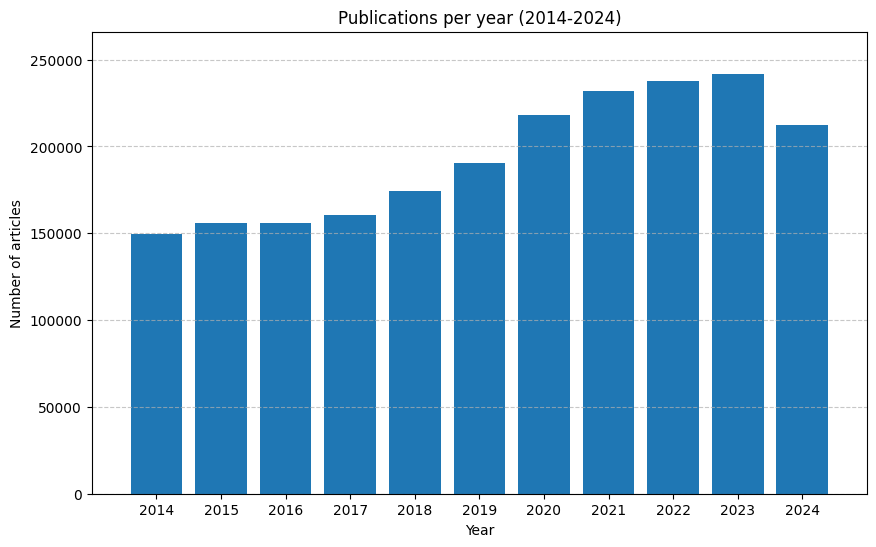

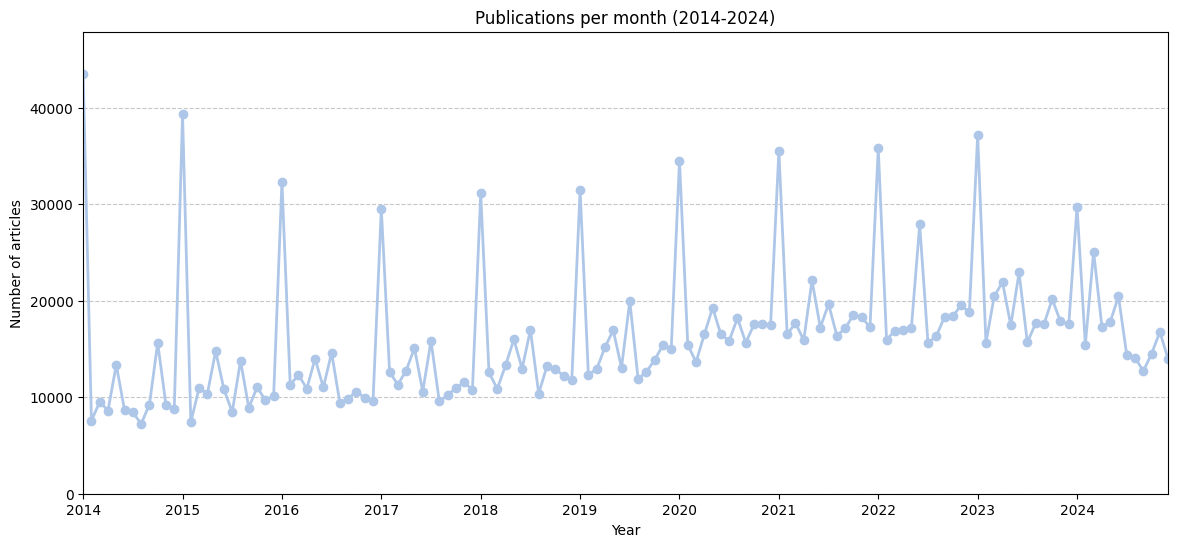

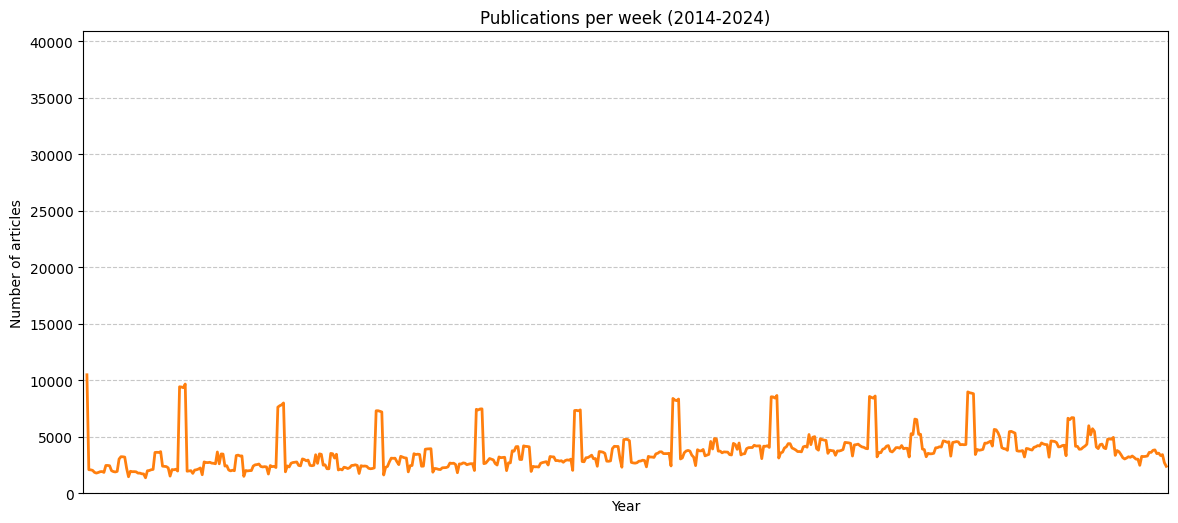

In [225]:
# Figure creation

# Import dataframe
os.chdir(output_directory)
file_path = "clean_df_step4.csv"

if 'clean_df_step4' in globals():
    figure_df = clean_df_step4.copy()
    print("figure_df copied from existing DataFrame!")
else:
    os.chdir(output_directory)
    clean_df_step4 = pd.read_csv(file_path)
    figure_df = clean_df_step4.copy()
    
figure_df['PubDate'] = pd.to_datetime(figure_df['PubDate'], errors='coerce')
figure_df['Year'] = figure_df['PubDate'].dt.year
figure_df['YearMonth'] = figure_df['PubDate'].dt.to_period('M').astype(str)
figure_df['YearWeek'] = figure_df['PubDate'].dt.to_period('W').astype(str)
figure_df = figure_df[figure_df['Year'].between(2014, 2025)]
yearly_counts = figure_df['Year'].value_counts().sort_index()
monthly_counts = figure_df['YearMonth'].value_counts().sort_index()
weekly_counts = figure_df['YearWeek'].value_counts().sort_index()
years = list(range(2015, 2026))
shifted_labels = list(range(2014, 2025))
colors = plt.cm.tab20.colors

print("Success!")

# ====== Yearly Publications ======
plt.figure(figsize=(10, 6))
plt.bar(yearly_counts.index + 1, yearly_counts.values, color=colors[0])  # Shift years +1 for alignment

# Styling
plt.xlabel('Year')
plt.ylabel('Number of articles')
plt.title('Publications per year (2014-2024)')
plt.xlim(2014, 2026)
plt.ylim(0, yearly_counts.max() * 1.1)
plt.xticks(years, shifted_labels) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# ====== Monthly Publications ======
plt.figure(figsize=(14, 6))
plt.plot(monthly_counts.index, monthly_counts.values, marker='o', linestyle='-', color=colors[1], linewidth=2)
plt.xticks([f"{year}-01" for year in range(2014, 2026)], range(2014, 2026))

plt.xlabel('Year')
plt.ylabel('Number of articles')
plt.title('Publications per month (2014-2024)')
plt.xlim(monthly_counts.index.min(), monthly_counts.index.max())
plt.ylim(0, monthly_counts.max() * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# ====== Weekly Publications ======
plt.figure(figsize=(14, 6))

weekly_counts_smoothed = weekly_counts.rolling(window=4, center=True).mean()
plt.plot(weekly_counts.index, weekly_counts_smoothed, linestyle='-', color=colors[2], linewidth=2)
plt.xticks([f"{year}-W01" for year in range(2014, 2026)], range(2014, 2026))

plt.xlabel('Year')
plt.ylabel('Number of articles')
plt.title('Publications per week (2014-2024)')
plt.xlim(weekly_counts.index.min(), weekly_counts.index.max())
plt.ylim(0, weekly_counts.max() * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()